# Plot validation between SUNTANS, ROMS and mooring data


In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
import os
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator


from mycurrents import oceanmooring as om
from soda.utils.modvsobs import ModVsObs

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'



In [2]:
# %matplotlib notebook

In [69]:
def plot_da(mo_T, mo_T_da, titlestr):
    # Mean temp
    ax3=plt.subplot2grid((1,3),(0,0),colspan=1)
    plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
    plt.plot(mo_T_da.meanMod, -mo_T.Z,'ko')
    plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
    plt.xlabel('Temperature [$^{\circ}$C]')
    plt.ylabel('Depth [m]')
    plt.grid(b=True)
    plt.xlim([7,30])
    plt.legend(('ROMS','ROMS-4DVAR','Obs.'), loc='upper left')

    # Bias
    ax4=plt.subplot2grid((1,3),(0,1),colspan=1)
    plt.plot(mo_T.bias, -mo_T.Z,'ro')
    plt.plot(mo_T_da.bias, -mo_T_da.Z,'ko')
    plt.xlim(-3.25,3.25)
    ax4.set_xticks([-2,-1,0,1,2])
    ax4.set_yticklabels([])
    plt.xlabel('Bias [$^{\circ}$C]')
    plt.grid(b=True)
    plt.title(titlestr)
    plt.vlines(0,-mo_T.Z[0],-mo_T.Z[-1], 'k', lw=1.5)


    # RMSE
    ax5=plt.subplot2grid((1,3),(0,2),colspan=1)
    plt.plot(mo_T.rmse, -mo_T.Z,'ro')
    plt.plot(mo_T_da.rmse, -mo_T_da.Z,'ko')
    plt.xlim(0,3)
    ax5.set_yticklabels([])
    plt.xlabel('RMSE [$^{\circ}$C]')
    plt.grid(b=True)
    plt.legend(('ROMS','ROMS-4DVAR'), loc='best')

    plt.tight_layout()

    #plt.savefig('../FIGURES/IMOS_v_SUNTANS_%s_%s.png'%(icdatastr,stationT), dpi=150)
    
def plot_da_uv(mo_T, mo_T_da, titlestr, units='m s$^{-1}$', nrows=1, startrow=0):
    # Mean temp
    ax3=plt.subplot2grid((nrows,3),(startrow,0),colspan=1)
    plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
    plt.plot(mo_T_da.meanMod, -mo_T.Z,'ko')
    plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
    plt.xlabel('Velocity [{}]'.format(units))
    plt.ylabel('Depth [m]')
    plt.grid(b=True)
    plt.xlim([-0.25,0.25])
    plt.ylim(-250,0)
    plt.legend(('ROMS','ROMS-4DVAR','Obs.'), loc='lower right')

    # Bias
    ax4=plt.subplot2grid((nrows,3),(startrow,1),colspan=1)
    plt.plot(mo_T.bias, -mo_T.Z,'ro')
    plt.plot(mo_T_da.bias, -mo_T_da.Z,'ko')
    plt.xlim(-0.25,0.25)
    ax4.set_xticks([-0.25,0,0.25])
    ax4.set_yticklabels([])
    plt.xlabel('Bias [{}]'.format(units))
    plt.grid(b=True)
    plt.vlines(0, -250, 0, linestyle='dashed')
    plt.ylim(-250,0)

    plt.title(titlestr)


    # RMSE
    ax5=plt.subplot2grid((nrows,3),(startrow,2),colspan=1)
    plt.plot(mo_T.rmse, -mo_T.Z,'ro')
    plt.plot(mo_T_da.rmse, -mo_T_da.Z,'ko')
    plt.xlim(0,0.3)
    ax5.set_yticklabels([])
    plt.xlabel('RMSE [{}]'.format(units))
    plt.grid(b=True)
    plt.legend(('ROMS','ROMS-4DVAR'), loc='best')
    plt.ylim(-250,0)

    plt.tight_layout()

    #plt.savefig('../FIGURES/IMOS_v_SUNT

In [6]:
dso

<xarray.Dataset>
Dimensions:        (NOMINAL_DEPTH: 18, TIME: 237890)
Coordinates:
    LATITUDE       float64 ...
    LONGITUDE      float64 ...
  * TIME           (TIME) datetime64[ns] 2017-02-06T00:00:01.000004608 ... 20...
  * NOMINAL_DEPTH  (NOMINAL_DEPTH) float64 19.1 28.6 38.6 ... 348.6 398.6 458.1
Data variables:
    TEMP           (NOMINAL_DEPTH, TIME) float64 ...

In [19]:
def load_roms(romsfile, romsvar, zobs):
    roms = om.from_netcdf(romsfile, romsvar)

    # Interpolate ROMS onto observed depths
    Fi = PchipInterpolator(roms.Z, roms.y, axis=0)
    return om.OceanMooring(roms.t, Fi(zobs), zobs)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


../FIGURES/InSitu_T_validation_4Dvar_ITFTIS_MarAprMay2017.png


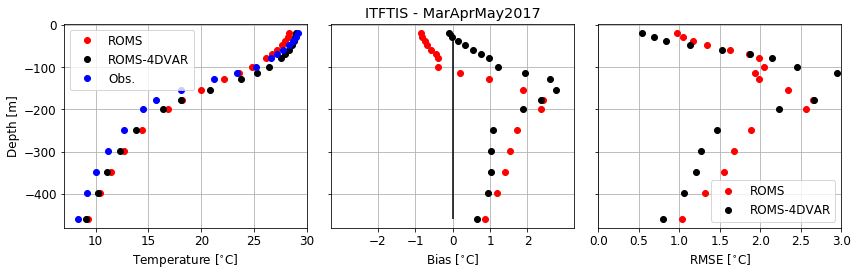

In [76]:

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
sitename = 'ITFTIS'
Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_TEMP_60s.nc'
dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso['TIME'].values, dso['TEMP'].values, dso['NOMINAL_DEPTH'].values)

########


roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)#Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'
romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)#Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'


zobs = -Tobsraw.Z

# Load the file w/out DA
romsvar = 'temp'
Tmod = load_roms(romsfile, 'temp', zobs)
Tmod_da = load_roms(roms4dvarfile, 'temp', zobs)
dt = (Tmod.t[1] - Tmod.t[0]).astype('timedelta64[s]').astype(float)

def plot_dates(t1,t2, mydatestr):
    
    Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

    mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

    mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
                Z=-zobs, units='degC', varname='romsvar', interpmodel=False)
    
    plt.figure(figsize=(12,4))
    titlestr = '{} - {}'.format(stationT, mydatestr)
    plot_da(mo_T, mo_T_da, titlestr)
    outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}.png'.format(sitename, mydatestr.strip(' '))
    print(outfile)
    return outfile


####


# outfile=plot_dates(np.datetime64('2017-02-04 00:00:00'),np.datetime64('2017-03-01 00:00:00'),'Feb2017')
# plt.savefig(outfile, dpi=150)
# outfile=plot_dates(np.datetime64('2017-03-01 00:00:00'),np.datetime64('2017-04-01 00:00:00'),'Mar2017')
# plt.savefig(outfile, dpi=150)
# outfile=plot_dates(np.datetime64('2017-04-01 00:00:00'),np.datetime64('2017-05-01 00:00:00'),'Apr2017')
# plt.savefig(outfile, dpi=150)
# outfile=plot_dates(np.datetime64('2017-05-01 00:00:00'),np.datetime64('2017-06-01 00:00:00'),'May2017')
# plt.savefig(outfile, dpi=150)

outfile=plot_dates(np.datetime64('2017-03-01 00:00:00'),np.datetime64('2017-06-01 00:00:00'),'MarAprMay2017')
plt.savefig(outfile, dpi=150)

# plt.savefig(outfile, dpi=150)
# print(t1,t2)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


../FIGURES/InSitu_T_validation_4Dvar_NP250_Apr2017.png
../FIGURES/InSitu_T_validation_4Dvar_NP250_3-15Apr2017.png
../FIGURES/InSitu_T_validation_4Dvar_NP250_15-30Apr2017.png


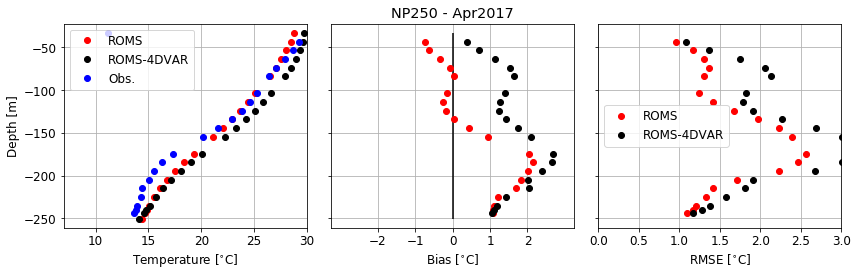

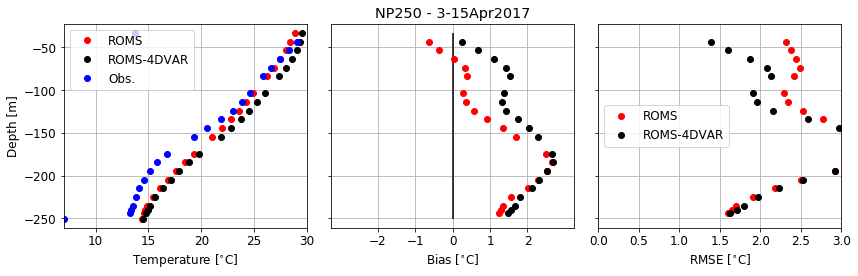

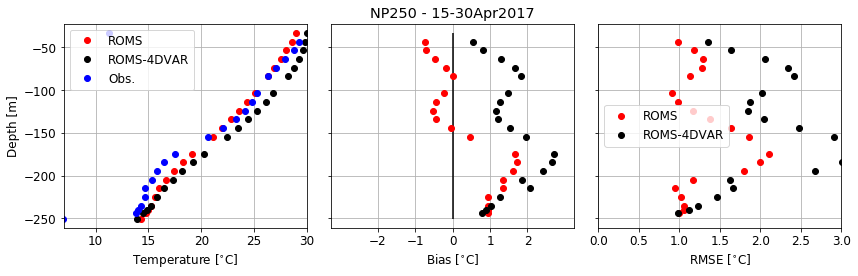

In [75]:

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
sitename = 'NP250'
Tfile = '../DATA/UWA_KISSME_NP250_fixedheight_T.nc'
dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso['time'].values, dso['Temperature'].values, dso['depth'].values)

########


roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)#Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'
romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)#Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'


zobs = -Tobsraw.Z

# Load the file w/out DA
romsvar = 'temp'
Tmod = load_roms(romsfile, 'temp', zobs)
Tmod_da = load_roms(roms4dvarfile, 'temp', zobs)
dt = (Tmod.t[1] - Tmod.t[0]).astype('timedelta64[s]').astype(float)

def plot_dates(t1,t2, mydatestr):
    
    Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

    mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

    mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
                Z=-zobs, units='degC', varname='romsvar', interpmodel=False)
    
    plt.figure(figsize=(12,4))
    titlestr = '{} - {}'.format(sitename, mydatestr)
    plot_da(mo_T, mo_T_da, titlestr)
    outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}.png'.format(sitename, mydatestr.strip(' '))
    print(outfile)
    return outfile


####


outfile=plot_dates(np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-05-03 00:00:00'),'Apr2017')
plt.savefig(outfile, dpi=150)

outfile=plot_dates(np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-04-15 00:00:00'),'3-15Apr2017')
plt.savefig(outfile, dpi=150)

outfile=plot_dates(np.datetime64('2017-04-15 00:00:00'),np.datetime64('2017-04-30 00:00:00'),'15-30Apr2017')
plt.savefig(outfile, dpi=150)



# plt.savefig(outfile, dpi=150)
# print(t1,t2)

# Compare velocity data

In [65]:
def load_velocity_mo(romsfile,  roms4dvarfile, obsvar, romsvar, t1, t2):
    uvfile = '../DATA/UWA_KISSME_SP250_fixedheight_uv.nc'

    dso = xr.open_dataset(uvfile)
    dso
    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.depth.values)
    zobs = -Uobsraw.Z
    xyin = np.array([dso.X, dso.Y])

    # Load the file w/out DA
    Umod = load_roms(romsfile, romsvar, zobs)
    Umod_da = load_roms(roms4dvarfile, romsvar, zobs)

    dt = (Umod.t[1] - Umod.t[0]).astype('timedelta64[s]').astype(float)

    # #Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
    Uobs = Uobsraw.clip(t1,t2).resample(dt,ndt=1)


    mo_U = ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)

    mo_U_da = ModVsObs(Umod_da.t, Umod_da.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)
    
    return mo_U, mo_U_da

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


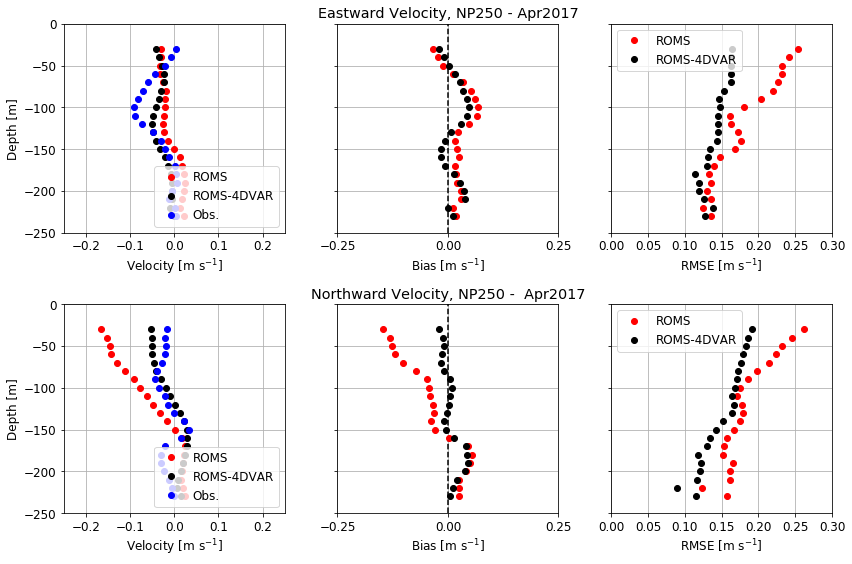

In [74]:
sitename = 'NP250'

roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)#Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'
romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)#Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'

t1,t2 = np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-05-03 00:00:00')
mydatestr = 'Apr2017'

mo_U, mo_U_da = load_velocity_mo(romsfile,roms4dvarfile, 'u', 'u_eastward', t1,t2)
mo_V, mo_V_da = load_velocity_mo(romsfile,roms4dvarfile, 'v', 'v_northward', t1,t2)

# ####
plt.figure(figsize=(12,8))
titlestr = 'Eastward Velocity, {} - {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_U, mo_U_da, titlestr, nrows=2, startrow=0)

#plt.figure(figsize=(12,4))
titlestr = 'Northward Velocity, {} -  {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_V, mo_V_da, titlestr, nrows=2, startrow=1)

outfile = '../FIGURES/InSitu_UV_validation_4Dvar_{}_{}.png'.format(sitename, mydatestr.strip(' '))
plt.savefig(outfile, dpi=150)

# # plot the surface velocty
# sfcidx = 0
# mo_U.Z[sfcidx]
# ylim=(-0.8,0.8)

# plt.figure(figsize=(12,6))
# ax=plt.subplot(211)

# plt.plot(mo_U_da.TSobs.t, mo_U_da.TSobs.y[sfcidx,:], 'b')
# plt.plot(mo_U.TSmod.t, mo_U.TSmod.y[sfcidx,:], 'r')
# plt.plot(mo_U_da.TSmod.t, mo_U_da.TSmod.y[sfcidx,:], 'k')
# plt.ylim(ylim)
# plt.xlim((t1,t2))

# plt.grid(b=True,ls=':')
# ax.set_xticklabels('')
# plt.ylabel('u [m/s]')
# plt.legend(('Obs.','ROMS','ROMS-4DVAR'), loc='upper right')

# plt.subplot(212)

# plt.plot(mo_V_da.TSobs.t, mo_V_da.TSobs.y[sfcidx,:], 'b')
# plt.plot(mo_V.TSmod.t, mo_V.TSmod.y[sfcidx,:], 'r')
# plt.plot(mo_V_da.TSmod.t, mo_V_da.TSmod.y[sfcidx,:], 'k')
# plt.ylim(ylim)
# plt.xlim((t1,t2))
# plt.grid(b=True,ls=':')
# plt.ylabel('v [m/s]')
# plt.xlabel('Date in 2017 [mm-dd HH]')

# outfile = '../FIGURES/InSitu_surfaceUV_timeseries_4Dvar_{}_{}.png'.format(stationT, days[fileno])
# plt.savefig(outfile, dpi=150)